## Using MCMC

https://stackoverflow.com/questions/17904783/dynamic-ode-based-model-in-pymc  
https://gist.github.com/gyromagnetic/6097271  

## Christopher Krapu: A Statistical ODE Model in PyMC3

A recurring theme in my posts is the power of combined statistical and physical/mechanistic models that are really only possible with modern Markov Chain Monte Carlo (MCMC) frameworks. In this post, I’ll go over how to make a statistical model out of a simple dynamical system. Let’s assume we have a system governed by the following equations: $\frac{dx}{dt}=−a⋅x(t)+y(t)$ where  $y$ is a forcing variable that varies over time. Both $x$ and $y$ are observed but a is unknown. We want to make a statistical inference about the values of $a$ and we’ll employ PyMC3 to do this.

https://ckrapu.github.io/2018/02/11/A-Statistical-ODE-Model-in-PyMC3.html

In [1]:
import theano.tensor as tt
import pymc3 as pm
import numpy as np
import theano
import matplotlib.pyplot as plt
%matplotlib inline


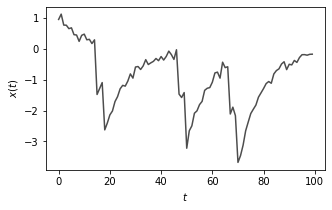

In [2]:
T = 100 # Number of timesteps

# Generate random noise
noise_stdev = 0.1
noise = np.random.randn(T) * noise_stdev

# We create a relatively sparse external forcing series
y =  np.random.randn(T)
y[y > -1.5] = 0  

a = 0.1    # Model's lone parameter
x0 = 1     # Initial value

# This function does a simple forward integration of the ODE
def f(x0,y,noise,a,T):
    x = np.zeros(T)
    x[0] = x0
    for i in range(1,T):
        x[i]=x[i-1] - a*x[i-1]+y[i]
    return x+noise

# Generate and plot the data
data = f(x0,y,noise,a,T)
plt.figure(figsize = (5,3))
_ = plt.plot(data,color = '0.3'),plt.ylabel('$x(t)$'),plt.xlabel('$t$')


In [3]:
# # The order of the arguments is very important - it must be exactly this way.
# # see the Theano scan documentation for the reason why.
# def fn_step(current_y,previous_x,coeff):
#     # Even though this looks like just a normal Python function,
#     # because it is using standard Python operators and Python is 
#     # not a strongly typed language, Theano can use this 
#     # and just drop in its own operators to overload + and *.
#     return previous_x - coeff*previous_x + current_y



In [4]:
# from pymc3.distributions import distribution

# floatX='float32' # This is just to fix an annoying casting issue that comes up when using scan

# class Dynamical(distribution.Continuous):

#     def __init__(self,coeff,sd,x0,y,*args,**kwargs):
# #         super(Dynamical,self).__init__(*args,**kwargs)
#         super().__init__(*args,**kwargs)
#         self.coeff = tt.as_tensor_variable(coeff)
#         self.sd    = tt.as_tensor_variable(sd)
#         self.x0    = tt.as_tensor_variable(x0)
#         self.y     = tt.as_tensor_variable(y)
    
#     # The uses of tt.cast are just to fix casting mismatches between float32 and float64 variables
#     def get_mu(self,x,x0,coeff,y):
#         # Here, we are saying that the vector mu is calculated by iteratively applying 
#         # the forward equation 'fn_step' and that it uses external sequence 'y'
#         # along with initial value 'coeff' (i.e. a scalar and non-sequence variable).
#         # The info about the output is the initial value 'x0'.
#         mu,_ = theano.scan(fn = fnstep.fn_step, outputs_info = tt.cast(x0,floatX),
#                      non_sequences=tt.cast(coeff,floatX),
#                            sequences=tt.cast(y,floatX))
#         return mu
    
#     def logp(self,x):
#         mu = self.get_mu(x,self.x0,self.coeff,self.y)
#         sd = self.sd 
#         return tt.sum(pm.Normal.dist(mu = mu,sd = sd).logp(x))


In [8]:
import dynamical
import fnstep

with pm.Model() as model:
    
    a_parameter = pm.Normal('a_parameter')
    sd = pm.HalfNormal('sd',sd = 0.2)
    x0 = pm.Flat('x0')
    x_testval = np.ones(len(y),dtype=np.float64)
    x  = dynamical.Dynamical('x',coeff = a_parameter, sd= sd, x0=x0, y = y,shape = len(y),
                   testval=x_testval)
    
    observations = pm.Normal('observations',mu = x, sd = 0.01,observed=data)
    trace = pm.sample() # Automatically applies the built-in No-U-Turn sampler



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, x0, sd, a_parameter]
Sampling 4 chains:   9%|██████▉                                                                   | 378/4000 [00:08<01:17, 46.86draws/s]
Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
Series([], )


ParallelSamplingError: Bad initial energy

In [ ]:
_ = pm.plot_posterior(trace,varnames=['a_parameter','x0','sd'])


In [ ]:
# to get software versions
# https://github.com/rasbt/watermark
# An IPython magic extension for printing date and time stamps, version numbers, and hardware information. 
# you only need to do this once
# !pip install watermark

%load_ext watermark
%watermark -v -m -p numpy,scipy,pymc3,theano,matplotlib -g 